In [69]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import astropy
import json
from sklearn.decomposition import PCA

np.set_printoptions(threshold=np.nan)

In [2]:
#Retrieve Parameters
params = pd.read_csv("ML_param.csv")
#params.values
#params.iterrows()
del params['coord_dec'] #Irrelevant (Hopefully) and poorly formatted for ML
del params['coord_ra']
del params['id']
del params['parent']


In [3]:
#Retrieve Training Set Classifications
csv_path = "../classifications/lsst_run_one.csv"
clsfn = pd.read_csv(csv_path)
subset = clsfn.loc[clsfn['workflow_name'] == "Difference Imaging Classifier"]
np.shape(subset)
im_class = []
for item, row in subset.iterrows():
    s_data = json.loads(row.subject_data) #Subject Data
    s_data = s_data.get(s_data.keys()[0])
    im=s_data.get(s_data.keys()[0])[47:-4]
    a_data = json.loads(row.annotations)[0] #Annotations
    classification = a_data['value']
    im_class.append([int(im),classification])
im_class = sorted(im_class)
#im_class

In [4]:
#Generate Data Frame that holds classifications and respective measured quantities
#This is done as a dataframe is a more cohesive object for data analysis
d = {}
for key in params.keys():
    d[key] = []
d["Classification"]=[]
im_data = params.set_index('image').T.to_dict()
for im in im_class:
    d["Classification"].append(im[1])
    d["image"].append(im[0])
    dat_dict = im_data.get(im[0])
    for key in dat_dict:
        d[key].append(dat_dict.get(key))
df = pd.DataFrame(d)
df

,Classification,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flag,...,ip_diffim_PsfDipoleFlux_neg_flag,ip_diffim_PsfDipoleFlux_neg_flux,ip_diffim_PsfDipoleFlux_neg_fluxSigma,ip_diffim_PsfDipoleFlux_pos_centroid_x,ip_diffim_PsfDipoleFlux_pos_centroid_xSigma,ip_diffim_PsfDipoleFlux_pos_centroid_y,ip_diffim_PsfDipoleFlux_pos_centroid_ySigma,ip_diffim_PsfDipoleFlux_pos_flag,ip_diffim_PsfDipoleFlux_pos_flux,ip_diffim_PsfDipoleFlux_pos_fluxSigma
0,Dipole,False,False,418.723064,312.574865,False,False,634.341850,413.852113,False,...,False,-108290.739145,2515.687520,226.605482,NaN,97.763873,NaN,False,108909.800974,2515.781488
1,Possible Transient,False,False,1113.044229,271.992518,False,False,1457.890048,384.214157,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
2,Possible Transient,False,False,1113.044229,271.992518,False,False,1457.890048,384.214157,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
3,Subtraction Error,False,False,50.727865,361.017537,False,False,378.971355,452.346159,False,...,False,-169510.699601,3340.836366,1517.001877,NaN,1003.116168,NaN,False,169312.388582,3339.446858
4,Subtraction Error,False,False,50.727865,361.017537,False,False,378.971355,452.346159,False,...,False,-169510.699601,3340.836366,1517.001877,NaN,1003.116168,NaN,False,169312.388582,3339.446858
5,Dipole,False,False,-94.296964,295.854271,False,False,-354.632066,402.071363,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
6,Subtraction Error,False,False,-94.296964,295.854271,False,False,-354.632066,402.071363,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
7,Subtraction Error,False,False,-94.296964,295.854271,False,False,-354.632066,402.071363,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
8,Subtraction Error,False,False,988.245036,332.570237,False,False,1282.432657,428.648099,False,...,False,-110961.702657,2952.702300,834.469493,NaN,1123.148906,NaN,False,111744.638382,2950.619325
9,Dipole,False,False,-70.508982,305.627756,False,False,-357.280112,408.644476,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


In [5]:
#Read in the features in the data frame, filter for columns relevant for ML
features = df.columns.tolist()

features = [c for c in features if c not in ["image", "Classification"]]
target = "Classification"  #Predict on Classifications

#Cut 'useless' features and problematic features
for feature in features:
    if df[feature].isnull().all():
        del df[feature]   
    elif np.mean(df[feature]) == np.inf:
        del df[feature]
    elif "flag" in feature: #Flags don't contribute to ML based on initial testing
        del df[feature]
        
features = df.columns.tolist()

features = [c for c in features if c not in ["image", "Classification"]]

In [6]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0, verbose = 1)
imp.fit(df[features])
features_imp = imp.transform(df[features])

In [7]:
#Random Forest
RFC =  RandomForestClassifier()
RFC = RFC.fit(features_imp,df[target])

In [8]:
feature_importance = zip(RFC.feature_importances_, features)
sorted(feature_importance, reverse=True)

[(0.18715372890638801, 'base_CircularApertureFlux_4_5_fluxSigma'),
 (0.097160653512064654, 'base_CircularApertureFlux_6_0_fluxSigma'),
 (0.072463949619717305, 'base_CircularApertureFlux_12_0_fluxSigma'),
 (0.050213009422948818, 'base_PeakLikelihoodFlux_fluxSigma'),
 (0.043882823745773805, 'base_CircularApertureFlux_17_0_fluxSigma'),
 (0.038119095452247502, 'base_PsfFlux_flux'),
 (0.035310174600904284, 'base_CircularApertureFlux_3_0_flux'),
 (0.034604396995589745, 'base_CircularApertureFlux_6_0_flux'),
 (0.033216348174638387, 'base_PeakLikelihoodFlux_flux'),
 (0.031448983001140206, 'ip_diffim_NaiveDipoleFlux_pos_fluxSigma'),
 (0.030645668005601329, 'base_CircularApertureFlux_9_0_flux'),
 (0.028616896692553313, 'base_CircularApertureFlux_3_0_fluxSigma'),
 (0.024438394429555345, 'ip_diffim_NaiveDipoleFlux_npos'),
 (0.022204523069939641, 'base_CircularApertureFlux_35_0_flux'),
 (0.022135548576195794, 'ip_diffim_NaiveDipoleFlux_pos_flux'),
 (0.016565901704985467, 'base_PsfFlux_fluxSigma'),


In [9]:
df.corr()

,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,...,ip_diffim_PsfDipoleFlux_centroid_y,ip_diffim_PsfDipoleFlux_chi2dof,ip_diffim_PsfDipoleFlux_neg_centroid_x,ip_diffim_PsfDipoleFlux_neg_centroid_y,ip_diffim_PsfDipoleFlux_neg_flux,ip_diffim_PsfDipoleFlux_neg_fluxSigma,ip_diffim_PsfDipoleFlux_pos_centroid_x,ip_diffim_PsfDipoleFlux_pos_centroid_y,ip_diffim_PsfDipoleFlux_pos_flux,ip_diffim_PsfDipoleFlux_pos_fluxSigma
base_CircularApertureFlux_12_0_flux,1.000000,0.036540,0.995484,0.036532,0.967055,0.802827,0.984789,0.033081,0.986195,0.036098,...,-0.010700,-0.159254,0.012242,-0.010890,-0.243170,0.362819,0.012463,-0.010509,0.246584,0.362698
base_CircularApertureFlux_12_0_fluxSigma,0.036540,1.000000,0.074519,1.000000,0.185895,0.373961,-0.026706,0.999913,-0.081567,0.999999,...,0.076328,0.598480,0.283417,0.076418,-0.012422,-0.261467,0.283645,0.076238,0.013941,-0.263880
base_CircularApertureFlux_17_0_flux,0.995484,0.074519,1.000000,0.074513,0.982121,0.834466,0.974467,0.071051,0.973163,0.074074,...,-0.115907,-0.139030,0.049995,-0.116102,-0.253601,0.384041,0.050120,-0.115712,0.256562,0.384192
base_CircularApertureFlux_17_0_fluxSigma,0.036532,1.000000,0.074513,1.000000,0.185890,0.373964,-0.026717,0.999913,-0.081578,0.999999,...,0.183179,-0.085028,0.243741,0.183259,0.165247,-0.191538,0.244296,0.183098,-0.165743,-0.191778
base_CircularApertureFlux_25_0_flux,0.967055,0.185895,0.982121,0.185890,1.000000,0.902469,0.934183,0.182428,0.925868,0.185451,...,-0.269870,-0.116580,0.035722,-0.270124,-0.208099,0.323620,0.035778,-0.269616,0.211227,0.324313
base_CircularApertureFlux_35_0_flux,0.802827,0.373961,0.834466,0.373964,0.902469,1.000000,0.751050,0.371520,0.730081,0.373642,...,-0.342294,0.036982,0.171868,-0.342399,-0.033423,0.353495,0.171829,-0.342187,0.035707,0.353568
base_CircularApertureFlux_3_0_flux,0.984789,-0.026706,0.974467,-0.026717,0.934183,0.751050,1.000000,-0.029674,0.993404,-0.027077,...,0.097949,-0.138533,-0.194338,0.097758,0.062833,0.056571,-0.194141,0.098140,-0.058215,0.056802
base_CircularApertureFlux_3_0_fluxSigma,0.033081,0.999913,0.071051,0.999913,0.182428,0.371520,-0.029674,1.000000,-0.084796,0.999933,...,0.157612,0.502222,0.301923,0.157622,-0.206845,0.031822,0.302436,0.157602,0.209169,0.029160
base_CircularApertureFlux_4_5_flux,0.986195,-0.081567,0.973163,-0.081578,0.925868,0.730081,0.993404,-0.084796,1.000000,-0.081979,...,0.082242,-0.094729,-0.152954,0.082041,-0.173743,0.211702,-0.152612,0.082444,0.178303,0.210907
base_CircularApertureFlux_4_5_fluxSigma,0.036098,0.999999,0.074074,0.999999,0.185451,0.373642,-0.027077,0.999933,-0.081979,1.000000,...,0.136337,0.537253,0.306482,0.136370,-0.155131,-0.041117,0.306925,0.136304,0.157350,-0.043744


In [10]:
#Split into Training Set and Testing Set

train = df.sample(frac=0.8, random_state=1)
test = df.loc[~df.index.isin(train.index)]

imp_tt = Imputer(missing_values='NaN', strategy='median', axis=0, verbose = 1)
imp_tt.fit(train[features])
features_imp_tt = imp_tt.transform(train[features])

#Random Forest Training/Test Split
RFC_tt =  RandomForestClassifier()
RFC_tt = RFC.fit(features_imp_tt,train[target])

In [11]:
imp_test = Imputer(missing_values='NaN', strategy='median', axis=0, verbose = 1)
imp_test.fit(test[features])
features_imp_test = imp_test.transform(test[features])


predictions = RFC_tt.predict(features_imp_test)


In [12]:
for index in range(len(predictions)):
    print predictions[index],",",test["Classification"].tolist()[index]

In [13]:
for index in range(len(predictions)):
    if predictions[index] != test["Classification"].tolist()[index]:
        print predictions[index],",",test["Classification"].tolist()[index],",",test["image"].tolist()[index]

In [14]:
from collections import Counter

In [15]:
pred_mapping = {}
for index in range(len(predictions)):
    pred_name = predictions[index]
    class_name = test["Classification"].tolist()[index]
    if pred_name in pred_mapping:
        pred_mapping[pred_name].append(class_name)
    else:
        pred_mapping[pred_name] = [class_name]
        
for pred_name, pred_value in pred_mapping.iteritems():
    print pred_name, Counter(pred_value)

In [16]:
agree=0
disagree=0
for index in range(len(predictions)):
    if predictions[index] == test["Classification"].tolist()[index]:
        agree+=1
    else:
        disagree+=1
print "Agree: "+ str(agree), "Disagree: "+str(disagree)
        

In [17]:
(75+82.)/(247+75)

0.48757763975155277

In [18]:
percent=float(agree)/len(predictions)
print percent

In [100]:
CAF45 = np.array(df['base_CircularApertureFlux_4_5_fluxSigma'])
CAF60 = np.array(df['base_CircularApertureFlux_6_0_fluxSigma'])
CAF60.shape

(1611,)

In [82]:
inds45 = np.where(CAF45>200000)
inds60 = np.where(CAF60>800000)
mask45 = lambda x: np.delete(x, inds45)
mask60 = lambda x: np.delete(x, inds60)
caf45 = mask45(CAF45)
caf60 = mask60(CAF60)

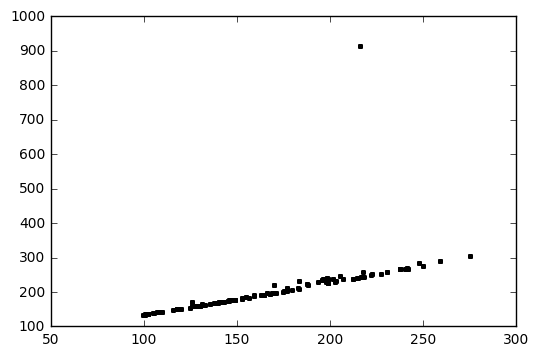

In [83]:
pl.plot(caf45,caf60,'k.')

In [73]:
pca = PCA(n_components = 10)
X2 = pca.fit_transform(feature_impor)

In [92]:
np.array(feature_importance).shape

(85, 2)

In [98]:
RFC.feature_importances_.shape

(85,)

In [99]:
classifications.shape

NameError: name 'classifications' is not defined